In [5]:
# Importing the FEM environment
import scipy
import scipy.sparse
import scipy.sparse.linalg
from fenics import *
import numpy
from random import random
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML
# HTML(X3DOM().html(u))

# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters['form_compiler']['cpp_optimize_flags'] = '-O3 -ffast-math -march=native'
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 4

fig_size = (9, 6)
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('ggplot')

The idea of the LOD method is to construct finite-dimensional space
$V_H^{ms} \subset V := H_0^1(\Omega)$ in which
convergence rates do not depend on $C(\epsilon^{-1})$. Therefore, accurate results can
be obtained by using low dimensional subspaces of the solution space $V$.

Define family of coarse mesh $\mathcal{T}_H$ assumed to consist of conforming
and shape regular simplicial elements.
Then define finite element space associated with the coarse mesh
$$V_H := \{ v_H \in V \, | \, \forall T \in \mathcal{T}_H: v_H|_T \in P_1 \}$$
In order to characterize the functions of the solution space $V := H_0^1(\Omega)$
that are not captured by $V_H$ define the space of finescale functions
$$W_H := \{ w \in  V \, | \, I_H w = 0 \} = \mbox{kern}I_H,$$
where $I_H$ is the quasi-interpolation operator $I_H \, : \, V \to V_H$.

Any function $v \in V$ can be decomposed as $v_H \in V_H$ plus $w_H \in W_H$,
where $v_H = I_H v$ is the nodal interpolation of $v$ at the vertices $x_j$ and
$w_H = (1-I_H) v$ is the error of interpolation. So solution space $V$ can be decomposed as
$$ V = V_H \oplus W_H $$
and for any $v \in V$ $$v = I_H v + (1 - I_H) v.$$

Keeping $W_H$ fixed, define a new low-dimensional (associated with $\mathcal{T}_H$)
space $V_H^{ms} \subset V$ as the subspace that satisfies
$$V = V_H^{ms} \oplus W_H \quad \mbox{and} \quad a(V_H^{ms}, W_H)=0,$$
i.e.,
$$V_H^{ms} := \{ v_H^{ms} \in V \, | \, \forall w \in W_H \, : \, a(v_H^{ms}, w)=0 \}$$
The Galerkin method with subspace $V_H^{ms}$ applied to model problem seeks
$u_H^{ms} \in V_H^{ms}$ such that
\begin{equation} 
    a(u_H^{ms}, v_H^{ms}) = L(v_H^{ms}) \quad \forall v_H^{ms} \in V_H^{ms}.
\end{equation}
Define correction operator $Q_H \, : \, V \to W_H$ to be the
$a$-orthogonal projection onto the subspace
$W_H \subset V$. Its complementary projection $(1 - Q_H)$ maps $V_H$ onto $V_H^{ms}$.
Now reformulating galerkin method as finite element method with modified bilinear form:
find $u_H \in V_H$ such that
\begin{equation}
    a(u_H - Q_H u_H, v_H - Q_H v_H) = L(v_H) \quad \forall v_H \in V_H
\end{equation}

In [2]:
from lod import *
from lod_mesh import MeshLOD

def error_calc_normal(h, e):

    mesh = UnitIntervalMesh(h)
    V = FunctionSpace(mesh, 'P', 1)

    f = Constant(1.0)

    bc = DirichletBC(V, Constant(0.0), "on_boundary")
    u = TrialFunction(V)
    v = TestFunction(V)

    epsilon = Constant(e)
    u_exact = Expression('x[0] - x[0]*x[0] + e*(1.0/(4.0*pi)*sin(2.0*pi*x[0]/e) - 1.0/(2.0*pi)*x[0]*sin(2.0*pi*x[0]/e) - e/(4.0*pi*pi)*cos(2.0*pi*x[0]/e) + e/(4.0*pi*pi))', e = epsilon, degree=4)
    A = Expression('1.0/(2.0 + cos( (2.0 * pi * x[0]) / epsilon))', degree = 1, epsilon = epsilon)
    epsilon.assign(e)

    a = inner(A*grad(u), grad(v))*dx
    L = f*v*dx
    
    u = Function(V)
    solve(a == L, u, bc)

    l2 = errornorm(u_exact, u, norm_type='l2')

    return l2

def error_calc_lod(h, e):

    mesh = UnitIntervalMesh(h)
    mesh_grid = MeshLOD(mesh)
    
    domains = mesh_grid.get_coarse_patches()
    domains_refined = mesh_grid.get_fine_patches()
    newmesh = mesh_grid.get_fine_mesh()
    v2d_fine = mesh_grid.get_vertex_to_dof_map_fine_mesh()
    v2d_coarse = mesh_grid.get_vertex_to_dof_map_coarse_mesh()

    # Define multiscale coefficient (model problem, exact solution is known)
    epsilon = Constant(e)
    u_exact = Expression('x[0] - x[0]*x[0] + e*(1.0/(4.0*pi)*sin(2.0*pi*x[0]/e) - 1.0/(2.0*pi)*x[0]*sin(2.0*pi*x[0]/e) - e/(4.0*pi*pi)*cos(2.0*pi*x[0]/e) + e/(4.0*pi*pi))', e = epsilon, degree=4)
    A = Expression('1.0/(2.0 + cos( (2.0 * pi * x[0]) / epsilon))', degree = 1, epsilon = epsilon)
    epsilon.assign(e)

    # Compute corrector matrix
    full_Qh = numpy.zeros((mesh.num_vertices(), newmesh.num_vertices()))
    for cell_index in range(mesh.num_cells()):
        full_Qh += local_solve(mesh, domains, newmesh, domains_refined, cell_index, v2d_fine, v2d_coarse, A=A, e=e)
    
    # Define global function spaces
    V_f = FunctionSpace(newmesh, 'P', 1)
    V_c = FunctionSpace(mesh, 'P', 1)

    P_h = compute_projection_matrix(V_c, V_f)

    # Store in sparse form
    sQ_h = scipy.sparse.csr_matrix(full_Qh)
    sP_h = scipy.sparse.csr_matrix(P_h)
    corr = sP_h + sQ_h

    kappa = interpolate(A, V_f)

    f = Constant(1.0)

    # Define variational form
    u = TrialFunction(V_f)
    v = TestFunction(V_f)
    a = inner(kappa*grad(u), grad(v))*dx
    L = f*v*dx

    # Assemble the forms in PETSc format
    A_h = PETScMatrix()
    assemble(a, tensor = A_h)
    b_h = PETScVector()
    assemble(L, tensor = b_h)

    # FIXME: Use PETSc instead of scipy
    ai, aj, av = A_h.mat().getValuesCSR()
    sA_h = scipy.sparse.csr_matrix((av, aj, ai))
    sb_h = scipy.sparse.csr_matrix(b_h.array())
    
    def boundary(x):
        return x[0] < DOLFIN_EPS or x[0] > 1 - DOLFIN_EPS
    bc = DirichletBC(V_c, Constant(0.0), boundary)
    
    A = corr*sA_h*corr.transpose() # coarse stiffness matrix
    b = corr*sb_h.T # coarse rhs

    non_dirichlet_dofs = [x for x in range(V_c.dim()) if x not in list(bc.get_boundary_values().keys())]

    # FIXME: rewrite to use fenics bc.apply()
    # slicing for dirichlet b.c.
    hh = A[non_dirichlet_dofs, :]
    hh = hh[:, non_dirichlet_dofs]
    x = numpy.zeros(mesh.num_vertices())
    x[non_dirichlet_dofs] = scipy.sparse.linalg.spsolve(hh, b[non_dirichlet_dofs])
    u = Function(V_c)
    u.vector()[:] = x

    l2 = errornorm(u_exact, u, norm_type='l2')

    # `u` function is now low-dimensional solution with high approximation property.
    # function on fine mesh can be obtained by
    #u_fine = corr.transpose()*x
    #u_f = Function(V_f)
    #u_f.vector()[:] = u_fine

    return l2


In [8]:
h_list = numpy.logspace(5, 9, num=40, dtype = 'int', base=2.0)

L2_err_normal = numpy.zeros((len(h_list)))
L2_err_lod = numpy.zeros((len(h_list)))

for i, hn in enumerate(h_list):
    L2_err_normal[i], L2_err_lod[i] = error_calc_normal(hn, 1e-2), error_calc_lod(hn, 1e-2)

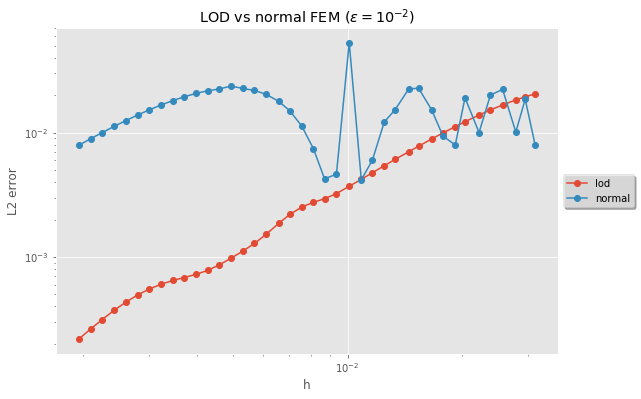

In [10]:
plt.loglog(1.0/h_list, L2_err_lod, 'o-', label='lod')
plt.loglog(1.0/h_list, L2_err_normal, 'o-', label='normal')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.xlabel("h")
plt.ylabel("L2 error")
plt.title("LOD vs normal FEM ($\epsilon = 10^{-2}$)")
plt.show()